#  Tutorial of Seq2seq with Attentions and Comparison

### 1) Read Data

reference : https://www.tensorflow.org/tutorials/text/nmt_with_attention

In [ ]:
import json
import io
import re
import os
import time
import random
import numpy as np
import unicodedata
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [ ]:
# %tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.4.0


In [ ]:
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

### 2) Text PreProcessing

#### (1) Text Cleaning

In [ ]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

In [ ]:
def preprocess_sentence(w,isTarget=False):
    w = unicode_to_ascii(w.lower().strip())

    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    if isTarget:
        w =  w + ' <end>'
    else:
        w = '<start> ' + w + ' <end>'
    
    return w

In [ ]:
en_sentence = u"May I borrow this book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"
print(preprocess_sentence(en_sentence,True))
print(preprocess_sentence(sp_sentence).encode('utf-8'))

may i borrow this book ? <end>
b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'


In [ ]:
def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')[:-1]

    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

    return zip(*word_pairs)

In [ ]:
en, sp = create_dataset(path_to_file, None)

In [ ]:
len(en)

118963

In [ ]:
print(en[29000])
print(sp[29000])

<start> tadpoles become frogs . <end>
<start> los renacuajos se convierten en ranas . <end>


#### (2) sentence tokenizing

In [ ]:
def max_length(tensor):
    return max(len(t) for t in tensor)

def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    
    lang_tokenizer.fit_on_texts(lang)
    
    tensor = lang_tokenizer.texts_to_sequences(lang)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,padding='post')
    
    return tensor, lang_tokenizer

In [ ]:
def load_dataset(path, num_examples=None):

    targ_lang, inp_lang = create_dataset(path, num_examples)

    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [ ]:
num_examples = 50000
input_tensor, output_tensor, input_tokenizer, output_tokenizer = load_dataset(path_to_file, num_examples)
max_length_targ, max_length_inp = max_length(output_tensor), max_length(input_tensor)

In [ ]:
max_length_output, max_length_input = max_length(output_tensor), max_length(input_tensor)

In [ ]:
input_tensor_train, input_tensor_val, output_tensor_train, output_tensor_val = train_test_split(input_tensor, output_tensor, test_size=0.2)
print(len(input_tensor_train), len(output_tensor_train), len(input_tensor_val), len(output_tensor_val))

40000 40000 10000 10000


In [ ]:
def convert(lang, tensor):
    for t in tensor:
        if t!=0:
            print ("%d ----> %s" % (t, lang.index_word[t]))

In [ ]:
print ("Input Language; index to word mapping")
convert(input_tokenizer, input_tensor_train[100])
print ()
print ("Target Language; index to word mapping")
convert(output_tokenizer, output_tensor_train[100])

Input Language; index to word mapping
1 ----> <start>
15 ----> me
291 ----> gustaria
1560 ----> besar
10 ----> a
43 ----> mary
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
4 ----> i
135 ----> d
34 ----> like
10 ----> to
576 ----> kiss
48 ----> mary
3 ----> .
2 ----> <end>


#### (3) DataSet Creating

In [ ]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, output_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 16]), TensorShape([64, 12]))

In [ ]:
example_input_batch.shape

TensorShape([64, 16])

### 2) Encoder

##### 1) Model

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(self.vocab_size, self.embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

##### 2) parameter

In [ ]:
INPUT_VOCAB_SIZE = len(input_tokenizer.word_index)+1
ENCODER_EMBEDDING_SIZE = 256
ENCODER_UNITS = 1024

In [ ]:
encoder = Encoder(INPUT_VOCAB_SIZE,ENCODER_EMBEDDING_SIZE,ENCODER_UNITS,BATCH_SIZE)

In [ ]:
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 16, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


### 3) Decoder

##### 1) DotProduct Attention

![](./DotProductAttention.png)

In [ ]:
class DotProductAttention(tf.keras.layers.Layer):
    def __init__(self,units):
        super(DotProductAttention,self).__init__()
        self.units = units
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        
    def call(self,hidden,encode_output):
        # query
        attention_query = self.W1(encode_output)
        
        # key
        attention_key = self.W2(hidden) 
        attention_key  = tf.expand_dims(attention_key ,axis = 1)
        
        # attention mechanism
        matmul_qk = tf.matmul(attention_query, attention_key, transpose_b=True)
        matmul_qk = tf.nn.tanh(matmul_qk)
        attention_weights = tf.nn.softmax(matmul_qk, axis=1)
        
        # attention dotproduct
        attention_values = encode_output
        context_vector = attention_weights * attention_values
        
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

![](./BahdanauAttention.png)

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [ ]:
ATTENTIION_UNITS = 64

In [ ]:
attentionLayer = DotProductAttention(ATTENTIION_UNITS)

In [ ]:
attention_result, attention_weights = attentionLayer(sample_hidden,sample_output)

In [ ]:
print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 16, 1)


In [ ]:
attentionLayer = BahdanauAttention(ATTENTIION_UNITS)

In [ ]:
attention_result, attention_weights = attentionLayer(sample_hidden,sample_output)

In [ ]:
print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 16, 1)


In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz,attention_name):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,return_sequences=True,return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)
        if attention_name =="dotproduct":
            self.attentionLayer = DotProductAttention(self.dec_units)
        elif attention_name == "Bahdanau":
            self.attentionLayer = BahdanauAttention(self.dec_units)
        else:
            raise ValueError("Unkown Attention Mechanism")
                

    def call(self,x,hidden,enc_output):
        
        x = self.embedding(x)
        context_vector, attention_weights = self.attentionLayer(hidden,enc_output)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, state = self.gru(x)
        output = tf.reshape(output, (-1, output.shape[2]))
        x = self.fc(output)
        return x, state,attention_weights

##### 2) Parameter

In [ ]:
### parameter
OUTPUT_VOCAB_SIZE = len(output_tokenizer.word_index)+1
DECODER_UNITS = ENCODER_UNITS
ENCODE_EMBEDDING_DIM = 256

In [ ]:
decoder = Decoder(OUTPUT_VOCAB_SIZE,ENCODE_EMBEDDING_DIM,DECODER_UNITS,BATCH_SIZE,"dotproduct")

In [ ]:
sample_decoder_output, _, _ = decoder(tf.random.uniform((64, 1)),sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 6817)


In [ ]:
decoder = Decoder(OUTPUT_VOCAB_SIZE,ENCODE_EMBEDDING_DIM,DECODER_UNITS,BATCH_SIZE,"Bahdanau")

In [ ]:
sample_decoder_output, _, _ = decoder(tf.random.uniform((64, 1)),sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 6817)


### 4) Define Loss Function

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

### 5)Seq2Seq Model

In [ ]:
class seq2seq(tf.keras.Model):
    def __init__(self,input_vocab_size,output_vocab_size, embedding_dim, enc_dec_units, batch_sz,attention_mechanism):
        super(seq2seq, self).__init__()
        self.encoder = Encoder(input_vocab_size,embedding_dim,enc_dec_units,batch_sz)
        self.decoder = Decoder(output_vocab_size,embedding_dim,enc_dec_units,batch_sz,attention_mechanism)

#### 1) dotproduct mechanism

In [ ]:
seq2seqModel= seq2seq(INPUT_VOCAB_SIZE,OUTPUT_VOCAB_SIZE,ENCODE_EMBEDDING_DIM,ENCODER_UNITS,BATCH_SIZE,"dotproduct")

In [ ]:
encoder_dotproduct = seq2seqModel.encoder

In [ ]:
decoder_dotproduct = seq2seqModel.decoder

### 6）Train Function

In [ ]:
@tf.function
def train_step(inp,tar,encoder,decoder):
    
    loss = 0
    
    with tf.GradientTape() as tape:
        
        encode_hidden = encoder.initialize_hidden_state()
        encode_output,encode_hidden = encoder(inp,encode_hidden)

        decode_hidden = encode_hidden

        decode_input = tf.expand_dims([output_tokenizer.word_index['<start>']] * BATCH_SIZE,1)

        for t in range(1,tar.shape[1]):
            
            predictions,decode_hidden,attention_weights = decoder(decode_input,decode_hidden,encode_output)

            loss += loss_function(tar[:,t],predictions)
            
            decode_input = tf.expand_dims(tar[:, t], 1)
        
    batch_loss = (loss / int(tar.shape[1]))
    
    variables = encoder.trainable_variables + decoder.trainable_variables
    
    gradients = tape.gradient(loss,variables)
    
    
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

In [ ]:
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE

In [ ]:
def train_func(encoder,decoder,EPOCHS):
    loss_list = []
    for epoch in range(EPOCHS):
        start = time.time()

        total_loss = 0

        for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
            batch_loss = train_step(inp,targ,encoder,decoder)
            total_loss += batch_loss

            if batch % 100 == 0:
                print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,batch, batch_loss.numpy()))
        
        loss_list.append(total_loss.numpy() / steps_per_epoch)
        
        print('Epoch {} Loss {:.4f}'.format(epoch + 1,total_loss / steps_per_epoch))
        print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    return loss_list

##### 1) Dotproduct Attention Training

In [ ]:
loss_list_dotproduct = train_func(encoder_dotproduct,decoder_dotproduct,10)

Epoch 1 Batch 0 Loss 4.8733
Epoch 1 Batch 100 Loss 2.3342
Epoch 1 Batch 200 Loss 1.9543
Epoch 1 Batch 300 Loss 2.0870
Epoch 1 Batch 400 Loss 1.7715
Epoch 1 Batch 500 Loss 1.8378
Epoch 1 Batch 600 Loss 1.7443
Epoch 1 Loss 2.0283
Time taken for 1 epoch 91.51159715652466 sec

Epoch 2 Batch 0 Loss 1.5796
Epoch 2 Batch 100 Loss 1.4832
Epoch 2 Batch 200 Loss 1.5143
Epoch 2 Batch 300 Loss 1.4006
Epoch 2 Batch 400 Loss 1.3657
Epoch 2 Batch 500 Loss 1.3932
Epoch 2 Batch 600 Loss 1.3106
Epoch 2 Loss 1.3958
Time taken for 1 epoch 80.90127205848694 sec

Epoch 3 Batch 0 Loss 1.0648
Epoch 3 Batch 100 Loss 0.9797
Epoch 3 Batch 200 Loss 1.0977
Epoch 3 Batch 300 Loss 1.0587
Epoch 3 Batch 400 Loss 1.0382
Epoch 3 Batch 500 Loss 0.9605
Epoch 3 Batch 600 Loss 1.0748
Epoch 3 Loss 1.0315
Time taken for 1 epoch 80.95814895629883 sec

Epoch 4 Batch 0 Loss 0.8808
Epoch 4 Batch 100 Loss 0.6992
Epoch 4 Batch 200 Loss 0.8128
Epoch 4 Batch 300 Loss 0.9684
Epoch 4 Batch 400 Loss 0.7370
Epoch 4 Batch 500 Loss 0.8631


In [ ]:
def translate(sentence,encoder,decoder):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    sentence = preprocess_sentence(sentence)

    inputs = [input_tokenizer.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],maxlen=max_length_input,padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''
    encode_hidden = [tf.zeros((1,DECODER_UNITS))]
    encode_output,encode_hidden = encoder(inputs,encode_hidden)
    
    decode_input = tf.expand_dims([output_tokenizer.word_index['<start>']],1)
    decode_hidden = encode_hidden

    predicted_ids = []
    for t in range(max_length_targ):
        
        predictions,decode_hidden,attention_weights = decoder(decode_input,decode_hidden,encode_output)
        
        attention_weights = tf.reshape(attention_weights, (-1, ))

        attention_plot[t] = attention_weights.numpy()
        
        predictions = predictions.numpy()
        predicted_id = np.argmax(predictions[0])
        
        if output_tokenizer.index_word[predicted_id] == '<end>':
            return result,attention_plot
        else:
            predicted_ids.append(predicted_id)

        result = ' '.join([output_tokenizer.index_word[predicted_id] for predicted_id in predicted_ids])

        decode_input = tf.expand_dims([predicted_id], 1)
        
    
    return result,attention_plot

In [ ]:
lines = io.open(path_to_file, encoding='UTF-8').read().strip().split('\n')[:-1][:num_examples]

In [ ]:
random_sample = random.randint(0,len(lines))
english, spanish  = lines[random_sample].split("\t")
result,_ = translate(spanish,encoder_dotproduct,decoder_dotproduct)
print("Spanish:%s"%spanish)
print("English:%s"%english)
print("Translated Result:%s"%result)

Spanish:Es demasiado sensible.
English:He is too sensitive.
Translated Result:it s too sensitive .


In [ ]:
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

Spanish:Todavía estoy ocupada.
English:I'm still busy.
Translated Result:i m still busy .


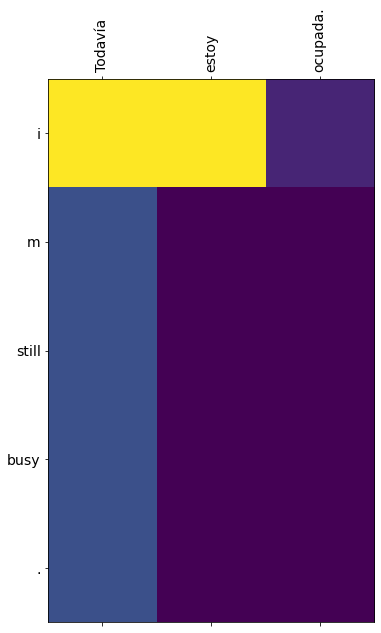

In [ ]:
random_sample = random.randint(0,len(lines))
english, spanish  = lines[random_sample].split("\t")
result,attention_plot = translate(spanish,encoder_dotproduct,decoder_dotproduct)
print("Spanish:%s"%spanish)
print("English:%s"%english)
print("Translated Result:%s"%result)
attention_plot = attention_plot[:len(result.split(' ')), :len(spanish.split(' '))]
plot_attention(attention_plot, spanish.split(' '), result.split(' '))

##### 2) Bahdanau Attention Training

In [ ]:
seq2seqModel= seq2seq(INPUT_VOCAB_SIZE,OUTPUT_VOCAB_SIZE,ENCODE_EMBEDDING_DIM,ENCODER_UNITS,BATCH_SIZE,"Bahdanau")

In [ ]:
encoder_Bahdanau = seq2seqModel.encoder

In [ ]:
decoder_Bahdanau = seq2seqModel.decoder

In [ ]:
@tf.function
def train_step(inp,tar,encoder,decoder):
    
    loss = 0
    
    with tf.GradientTape() as tape:
        
        encode_hidden = encoder.initialize_hidden_state()
        encode_output,encode_hidden = encoder(inp,encode_hidden)

        decode_hidden = encode_hidden

        decode_input = tf.expand_dims([output_tokenizer.word_index['<start>']] * BATCH_SIZE,1)

        for t in range(1,tar.shape[1]):
            
            predictions,decode_hidden,attention_weights = decoder(decode_input,decode_hidden,encode_output)

            loss += loss_function(tar[:,t],predictions)
            
            decode_input = tf.expand_dims(tar[:, t], 1)
        
    batch_loss = (loss / int(tar.shape[1]))
    
    variables = encoder.trainable_variables + decoder.trainable_variables
    
    gradients = tape.gradient(loss,variables)
    
    
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

In [ ]:
loss_list_Bahdanau = train_func(encoder_Bahdanau,decoder_Bahdanau,10)

Epoch 1 Batch 0 Loss 4.8737
Epoch 1 Batch 100 Loss 2.1003
Epoch 1 Batch 200 Loss 1.7651
Epoch 1 Batch 300 Loss 1.5895
Epoch 1 Batch 400 Loss 1.2370
Epoch 1 Batch 500 Loss 1.2626
Epoch 1 Batch 600 Loss 1.0943
Epoch 1 Loss 1.6076
Time taken for 1 epoch 93.7564263343811 sec

Epoch 2 Batch 0 Loss 1.0543
Epoch 2 Batch 100 Loss 0.9748
Epoch 2 Batch 200 Loss 0.7767
Epoch 2 Batch 300 Loss 0.6984
Epoch 2 Batch 400 Loss 0.7408
Epoch 2 Batch 500 Loss 0.5344
Epoch 2 Batch 600 Loss 0.6508
Epoch 2 Loss 0.8120
Time taken for 1 epoch 83.67918491363525 sec

Epoch 3 Batch 0 Loss 0.4954
Epoch 3 Batch 100 Loss 0.6069
Epoch 3 Batch 200 Loss 0.5464
Epoch 3 Batch 300 Loss 0.3767
Epoch 3 Batch 400 Loss 0.5286
Epoch 3 Batch 500 Loss 0.4499
Epoch 3 Batch 600 Loss 0.4251
Epoch 3 Loss 0.4684
Time taken for 1 epoch 83.68306112289429 sec

Epoch 4 Batch 0 Loss 0.2458
Epoch 4 Batch 100 Loss 0.3195
Epoch 4 Batch 200 Loss 0.2673
Epoch 4 Batch 300 Loss 0.3584
Epoch 4 Batch 400 Loss 0.2774
Epoch 4 Batch 500 Loss 0.3024
E

Spanish:Cierra el gas.
English:Turn off the gas.
Translated Result:turn off the gas .


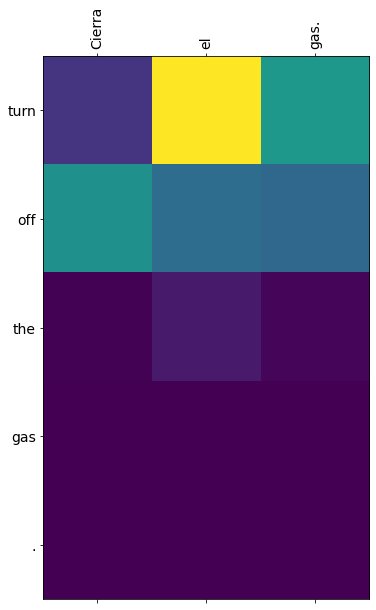

In [ ]:
random_sample = random.randint(0,len(lines))
english, spanish  = lines[random_sample].split("\t")
result,attention_plot = translate(spanish,encoder_Bahdanau,decoder_Bahdanau)
print("Spanish:%s"%spanish)
print("English:%s"%english)
print("Translated Result:%s"%result)
attention_plot = attention_plot[:len(result.split(' ')), :len(spanish.split(' '))]
plot_attention(attention_plot, spanish.split(' '), result.split(' '))


In [ ]:
plt.figure(figsize=(8,6))
l1 = plt.plot(loss_list_dotproduct,label ="dotProduct Attention")
l2 = plt.plot(loss_list_Bahdanau,label ="Bahdanau Attention")
plt.xlabel("Epoch",fontsize='small')
plt.ylabel("Loss",fontsize='small')
plt.legend(loc='best')
plt.title("DotProduct VS Bahdanau")

![](./AttentionComparison.png)